In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor




In [3]:
DATA_PATH = "high_diamond_ranked_10min.csv"
unprocess_data = pd.read_csv(DATA_PATH)


In [4]:
unprocess_data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [5]:
unprocess_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [6]:
#after checking for null and inconsistent changing name for easier work
data = unprocess_data

In [7]:
target = "blueWins"

base_cols = [c for c in data.columns if c not in ['blueWins', 'redWins']]

#blue - red
diff_features = {}
for col in base_cols:
    if col.startswith("blue"):
        red_col = col.replace("blue", "red")
        if red_col in data.columns:
            diff_features[col.replace("blue", "diff")] = data[col] - data[red_col]

data_diff = pd.DataFrame(diff_features)
data_final = pd.concat([data_diff, data[target]], axis=1)

print(data_final.shape)
data_final.head()


(9879, 20)


,diffWardsPlaced,diffWardsDestroyed,diffFirstBlood,diffKills,diffDeaths,diffAssists,diffEliteMonsters,diffDragons,diffHeralds,diffTowersDestroyed,diffTotalGold,diffAvgLevel,diffTotalExperience,diffTotalMinionsKilled,diffTotalJungleMinionsKilled,diffGoldDiff,diffExperienceDiff,diffCSPerMin,diffGoldPerMin,blueWins
0,13,-4,1,3,-3,3,0,0,0,0,643,-0.2,-8,-2,-19,1286,-16,-0.2,64.3,0
1,0,0,-1,0,0,3,-2,-1,-1,-1,-2908,-0.2,-1173,-66,-9,-5816,-2346,-6.6,-290.8,0
2,0,-3,-1,-4,4,-10,1,1,0,0,-1172,-0.4,-1033,-17,18,-2344,-2066,-1.7,-117.2,0
3,28,-1,-1,-1,1,-5,1,0,1,0,-1321,0.0,-7,-34,8,-2642,-14,-3.4,-132.1,0
4,58,2,-1,0,0,-1,-1,-1,0,0,-1004,0.0,230,-15,-10,-2008,460,-1.5,-100.4,0


In [8]:
#take all 19 column to use as predictor and 'blueWins' for target
X = data_final.drop(columns=["blueWins"])
y = data_final["blueWins"]


In [22]:
#to find and remove unnecessary predictor by checking the correlation with each predictor to other predictor.
# Compute absolute correlation matrix
corr_matrix = X.corr().abs()

high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = high_corr[high_corr > 0.9].dropna(how='all').dropna(axis=1, how='all')

print(high_corr)


                        diffDeaths  diffTotalGold  diffTotalExperience  \
diffKills                      1.0       0.917008                  NaN   
diffDeaths                     NaN       0.917008                  NaN   
diffTotalGold                  NaN            NaN                  NaN   
diffAvgLevel                   NaN            NaN             0.919161   
diffTotalExperience            NaN            NaN                  NaN   
diffTotalMinionsKilled         NaN            NaN                  NaN   
diffGoldDiff                   NaN            NaN                  NaN   

                        diffGoldDiff  diffExperienceDiff  diffCSPerMin  \
diffKills                   0.917008                 NaN           NaN   
diffDeaths                  0.917008                 NaN           NaN   
diffTotalGold               1.000000                 NaN           NaN   
diffAvgLevel                     NaN            0.919161           NaN   
diffTotalExperience              NaN 

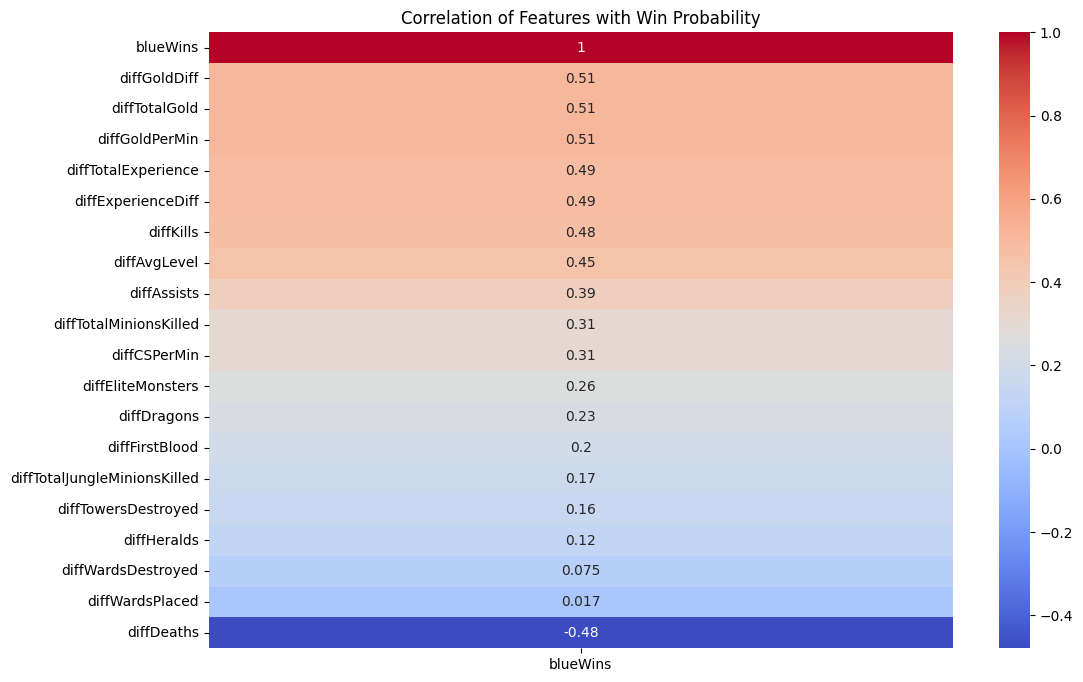

In [10]:
corr = X.join(y).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr[['blueWins']].sort_values(by='blueWins', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Win Probability')
plt.show()

In [11]:
#final set 
X_corr= data_final[['diffExperienceDiff', 'diffAssists', 'diffWardsPlaced', 'diffWardsDestroyed','diffFirstBlood', 'diffEliteMonsters', 'diffTotalMinionsKilled','diffTotalJungleMinionsKilled', 'diffTowersDestroyed','diffTotalGold','diffKills']]
y_corr=data_final['blueWins']

In [12]:
X_diff = sm.add_constant(X_corr)
vif_data = pd.DataFrame()
vif_data["feature"] = X_diff.columns
vif_data["VIF"] = [variance_inflation_factor(X_diff.values, i) for i in range(len(X_diff.columns))]

print(vif_data)

                         feature        VIF
0                          const   1.010084
1             diffExperienceDiff   7.578570
2                    diffAssists   3.937883
3                diffWardsPlaced   1.023629
4             diffWardsDestroyed   1.034662
5                 diffFirstBlood   1.266862
6              diffEliteMonsters   1.190585
7         diffTotalMinionsKilled   3.134960
8   diffTotalJungleMinionsKilled   1.779982
9            diffTowersDestroyed   1.572993
10                 diffTotalGold  23.213020
11                     diffKills  13.870939


In [13]:
#remove high VIF (which could lead to multicollinearity)
X_final =data_final[['diffExperienceDiff', 'diffAssists', 'diffWardsPlaced', 'diffWardsDestroyed','diffFirstBlood', 'diffEliteMonsters', 'diffTotalMinionsKilled','diffTotalJungleMinionsKilled', 'diffTowersDestroyed',"diffKills"]]
y_final = data_final['blueWins']

In [14]:
#recheck vif to make sure everything <10
X_diff = sm.add_constant(X_final)
vif_data = pd.DataFrame()
vif_data["feature"] = X_diff.columns
vif_data["VIF"] = [variance_inflation_factor(X_diff.values, i) for i in range(len(X_diff.columns))]

print(vif_data)

                         feature       VIF
0                          const  1.008165
1             diffExperienceDiff  6.849835
2                    diffAssists  3.474902
3                diffWardsPlaced  1.023620
4             diffWardsDestroyed  1.034121
5                 diffFirstBlood  1.208423
6              diffEliteMonsters  1.187636
7         diffTotalMinionsKilled  1.981012
8   diffTotalJungleMinionsKilled  1.597434
9            diffTowersDestroyed  1.124037
10                     diffKills  8.141421


In [15]:
#split data 20/80 test/train
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y, random_state=42)


In [16]:
#scale data to normalize features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

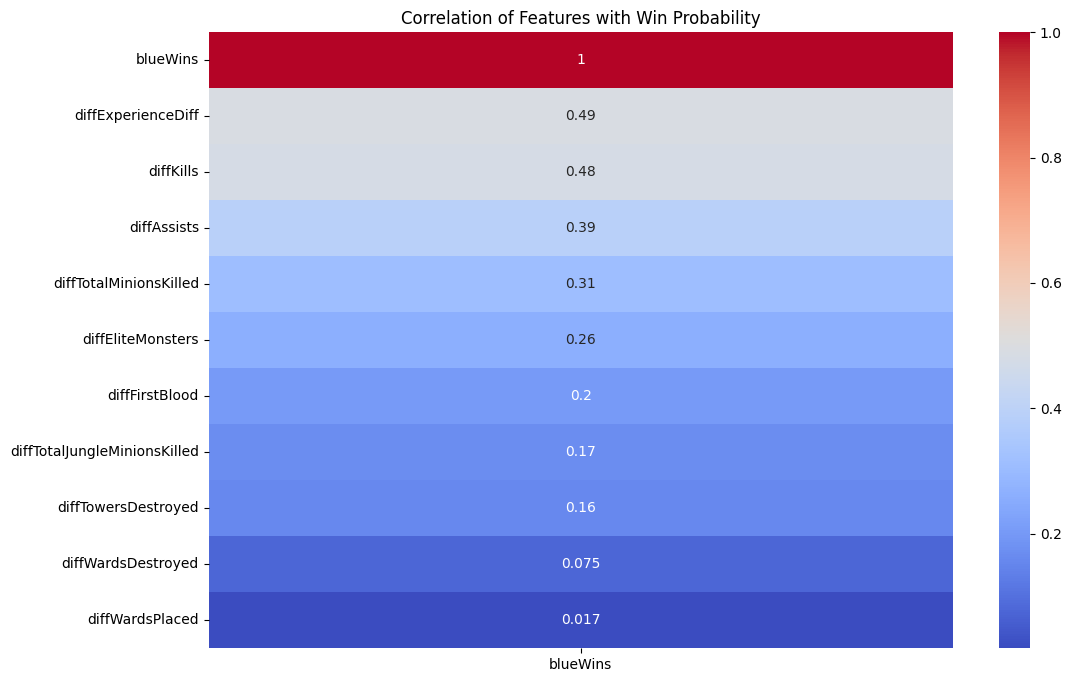

                              diffExperienceDiff  diffAssists  \
diffExperienceDiff                      1.000000     0.605836   
diffAssists                             0.605836     1.000000   
diffWardsPlaced                         0.038276     0.048836   
diffWardsDestroyed                      0.123670     0.124672   
diffFirstBlood                          0.240665     0.303375   
diffEliteMonsters                       0.312598     0.255418   
diffTotalMinionsKilled                  0.625556     0.266344   
diffTotalJungleMinionsKilled            0.375999     0.032332   
diffTowersDestroyed                     0.296233     0.163933   
diffKills                               0.822845     0.830751   
blueWins                                0.489558     0.385866   

                              diffWardsPlaced  diffWardsDestroyed  \
diffExperienceDiff                   0.038276            0.123670   
diffAssists                          0.048836            0.124672   
diffWardsPla

In [17]:
corr = X_final.join(y_final).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr[['blueWins']].sort_values(by='blueWins', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Win Probability')
plt.show()
print(corr)

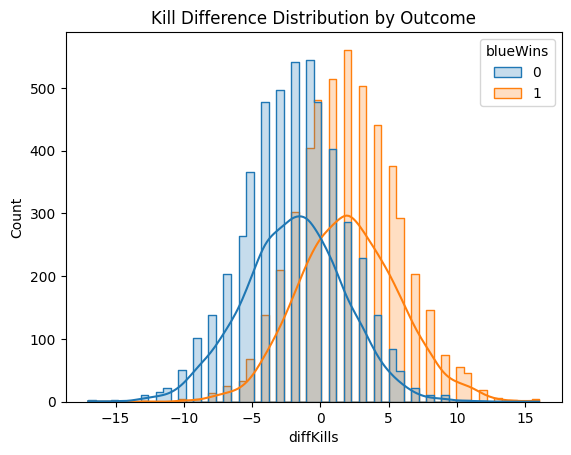

In [18]:
X_diff = sm.add_constant(X_final)
sns.histplot(data=X_diff.join(y), x='diffKills', hue='blueWins', kde=True, element='step')
plt.title('Kill Difference Distribution by Outcome')
plt.show()


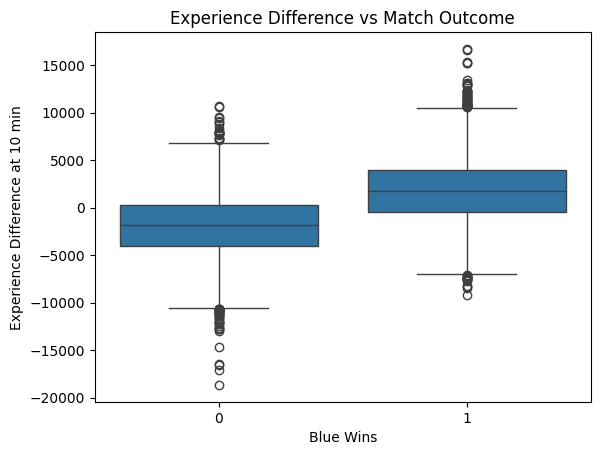

In [19]:
sns.boxplot(x=y, y=X_diff['diffExperienceDiff'])
plt.xlabel('Blue Wins')
plt.ylabel('Experience Difference at 10 min')
plt.title('Experience Difference vs Match Outcome')
plt.show()



Top Random Forest Importances:


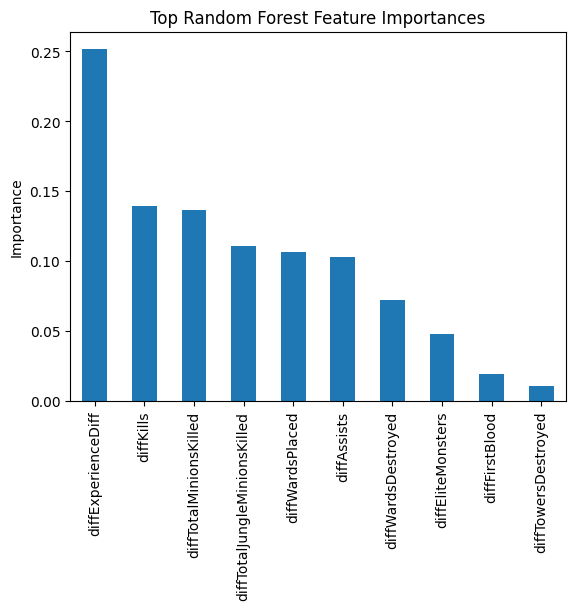

In [20]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_final, y_final)

rf_importances = pd.Series(rf.feature_importances_, index=X_final.columns).sort_values(ascending=False)
print("Top Random Forest Importances:")


plt.figure()
rf_importances.plot(kind="bar")
plt.title("Top Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()